# Environment Import

In [24]:
import time

import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.recommendation import ALS
from pyspark.ml.regression import RandomForestRegressor
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, collect_list, split, explode, avg, udf, expr

# Part 1: Init Spark Session with Ratings

In [54]:
def init_spark_session_with_ratings():
    """
    Reads the ratings file and returns the SparkSession and DataFrame created from the file.

    Returns:
    SparkSession, DataFrame: The Spark session and the DataFrame created from the ratings file.
    """

    # Initialize Spark session
    spark = SparkSession.builder \
        .appName("MovieRecommend") \
        .config("spark.executor.memory", "8g") \
        .config("spark.executor.cores", "4") \
        .config("spark.executor.instances", "4") \
        .config("spark.driver.memory", "8G") \
        .getOrCreate()

    ratings_df = spark.read.csv("dataset/ratings.csv", header=True, inferSchema=True)
    print(ratings_df)
    ratings_df.show()

    return spark, ratings_df


spark, ratings_df = init_spark_session_with_ratings()

DataFrame[userId: int, movieId: int, rating: double, timestamp: int]
+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    296|   5.0|1147880044|
|     1|    306|   3.5|1147868817|
|     1|    307|   5.0|1147868828|
|     1|    665|   5.0|1147878820|
|     1|    899|   3.5|1147868510|
|     1|   1088|   4.0|1147868495|
|     1|   1175|   3.5|1147868826|
|     1|   1217|   3.5|1147878326|
|     1|   1237|   5.0|1147868839|
|     1|   1250|   4.0|1147868414|
|     1|   1260|   3.5|1147877857|
|     1|   1653|   4.0|1147868097|
|     1|   2011|   2.5|1147868079|
|     1|   2012|   2.5|1147868068|
|     1|   2068|   2.5|1147869044|
|     1|   2161|   3.5|1147868609|
|     1|   2351|   4.5|1147877957|
|     1|   2573|   4.0|1147878923|
|     1|   2632|   5.0|1147878248|
|     1|   2692|   5.0|1147869100|
+------+-------+------+----------+
only showing top 20 rows



# Part 2: Basic Recommend with Visualization

In [55]:
def basic_recommend(spark, ratings_df):
    """
    Performs basic movie recommendation based on the average rating.

    Args:
    ratings_df (DataFrame): The DataFrame containing movie ratings.
    """

    # Compute the average rating for each movie
    avg_ratings_df = ratings_df.groupBy("movieId").agg(avg("rating").alias("avg_rating"))

    # Join with the movies DataFrame to get the movie titles and genres
    movies_df = spark.read.csv("dataset/movies.csv", header=True, inferSchema=True)
    joined_df = avg_ratings_df.join(movies_df, "movieId").withColumn("genres", split(col("genres"), "\\|"))

    # Join with the tags DataFrame to get the movie tags, and aggregate tags into a single string for each movie
    tags_df = spark.read.csv("dataset/tags.csv", header=True, inferSchema=True)
    joined_df = joined_df.join(tags_df, "movieId").withColumn("tag", col("tag")). \
        groupBy("movieId", "title", "genres", "avg_rating"). \
        agg(expr("concat('[', concat_ws(', ', collect_list(tag)), ']')").alias("tags")
            )

    # Retrieve top 5 movies based on average ratings
    top_movies = joined_df.orderBy(col("avg_rating"), ascending=False).limit(5)
    top_movies.show()

    return top_movies


top_movies = basic_recommend(spark, ratings_df)

+-------+--------------------+--------------------+----------+--------------------+
|movieId|               title|              genres|avg_rating|                tags|
+-------+--------------------+--------------------+----------+--------------------+
| 133307|Time Zero: The La...|       [Documentary]|       5.0|          [business]|
| 136988|The Good Mistress...|             [Drama]|       5.0|          [tv movie]|
| 130206|Picture Mommy Dea...|            [Horror]|       5.0|[doll, fire, hawk...|
| 147615|The Battle of Lov...|[(no genres listed)]|       5.0|[Troma Entertainm...|
| 116243|    Convicted (1931)|   [Drama, Thriller]|       5.0|          [suspense]|
+-------+--------------------+--------------------+----------+--------------------+



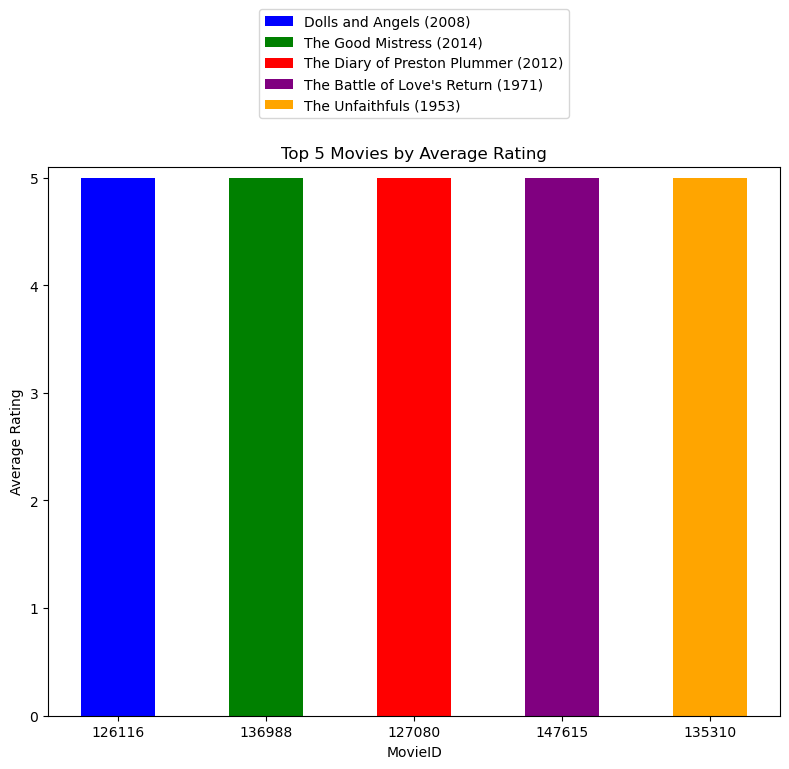

In [56]:
def basic_recommend_visualization(top_movies):
    # Convert Spark DataFrame to Pandas DataFrame for plotting
    top_movies_pd = top_movies.toPandas()

    # Define colors for each movie (you can customize this)
    colors = ['blue', 'green', 'red', 'purple', 'orange']

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot each movie as a separate bar
    for i, row in enumerate(top_movies_pd.itertuples(), start=1):
        movie_id = row.movieId
        movie_title = row.title
        avg_rating = row.avg_rating  # Use the column name 'avg_rating'
        color = colors[i - 1]

        # Plot the bar with the movie title as label
        ax.bar(str(movie_id), avg_rating, width=0.5, color=color, label=movie_title)

    # Set labels and title
    ax.set_xlabel('MovieID')
    ax.set_ylabel('Average Rating')
    ax.set_title('Top 5 Movies by Average Rating')

    # Ensure that the top of the bars are within the visible range of the plot
    plt.ylim(0, 5.1)

    # Rotate movie titles for better visibility
    plt.xticks()

    # Add a legend to explain the colors
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3))

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Close the plt object to free memory
    plt.close()


basic_recommend_visualization(top_movies)

# Part3: ALS Recommend with Visualization

## 3.1 Optimal Parameters Chosen

In [34]:
def als_recommend(spark, ratings_df):
    """
    Performs movie recommendations using the ALS (Alternating Least Squares).

    Args:
    spark (SparkSession): SparkSession object for DataFrame operations.
    ratings_df (DataFrame): The DataFrame containing movie ratings.
    """

    # Split the dataset into training and test sets
    (training, test) = ratings_df.randomSplit([0.7, 0.3])

    # Create an ALS model
    als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop", nonnegative=True)

    # Define a grid of parameters for tuning
    param_grid = {
        "rank": [10, 20],
        "maxIter": [5, 10],
        "regParam": [0.01, 0.1]
    }

    # Define multiple evaluators
    rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
    mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")

    # Variables to keep track of the best model and its performance
    best_rmse = float('inf')
    best_error = float('inf')
    best_params = None
    results = []

    # Grid search through the parameter space
    for rank in param_grid["rank"]:
        for max_iter in param_grid["maxIter"]:
            for reg_param in param_grid["regParam"]:
                start_time = time.time()

                # Set model parameters
                als.setParams(rank=rank, maxIter=max_iter, regParam=reg_param)
                
                # Fit ALS model on training data
                model = als.fit(training)
                
                # Evaluate the model on test data
                predictions = model.transform(test)
                rmse = rmse_evaluator.evaluate(predictions)
                mae = mae_evaluator.evaluate(predictions)
                training_time = time.time() - start_time

                # Append results
                results.append({
                    "rank": rank, "maxIter": max_iter, "regParam": reg_param,
                    "RMSE": rmse, "MAE": mae, "Training Time": training_time
                })

                # Update best model
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = (rank, max_iter, reg_param)

    # Save the results DataFrame to a CSV file
    results_df = pd.DataFrame(results)
    print(results_df)

    # Display the best model parameters and its RMSE
    print("Best Parameters:", best_params)
    print("Best RMSE:", best_error)


als_recommend(spark, ratings_df)

23/11/30 05:57:49 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


   rank  maxIter  regParam      RMSE       MAE  Training Time
0    10        5      0.01  0.825941  0.633159      50.297239
1    10        5      0.10  0.836363  0.657834      41.593888
2    10       10      0.01  0.809125  0.616715      50.678657
3    10       10      0.10  0.816359  0.635026      47.101259
4    20        5      0.01  0.827361  0.630171      52.242215
5    20        5      0.10  0.830011  0.652032      51.620835
6    20       10      0.01  0.817267  0.618935      73.576302
7    20       10      0.10  0.811902  0.631312      64.943924
Best Parameters: (10, 10, 0.01)
Best RMSE: inf


## 3.2 ALS Recommend With Optimal Parameters

In [57]:
def als_recommend_best(spark, ratings_df):
    """
    Performs movie recommendations using the ALS (Alternating Least Squares) model with optimal parameters.

    Args:
    spark (SparkSession): SparkSession object for DataFrame operations.
    ratings_df (DataFrame): The DataFrame containing movie ratings.
    """

    # Split the dataset into training and test sets
    (training, test) = ratings_df.randomSplit([0.7, 0.3])

    # Define multiple evaluators
    rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
    mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")

    # Create an ALS model
    als = ALS(rank=10, maxIter=10, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")
   
    # Fit ALS model on training data
    model = als.fit(training)

    # Evaluate the model on test data
    predictions = model.transform(test)
    rmse = rmse_evaluator.evaluate(predictions)
    mae = mae_evaluator.evaluate(predictions)
    print(f"Root Mean Square Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")

    # Generate top 5 movie recommendations for each user using the best model
    recommendations = model.recommendForAllUsers(5)
    recommendations.show(truncate=False)
    
    return recommendations


recommendations = als_recommend_best(spark, ratings_df)

Root Mean Square Error (RMSE): 0.8088804712280285
Mean Absolute Error (MAE): 0.613862796057211


+------+---------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                          |
+------+---------------------------------------------------------------------------------------------------------+
|31    |[{174403, 6.799754}, {128874, 6.0103164}, {158888, 5.9108367}, {128536, 5.7379894}, {176235, 5.615964}]  |
|34    |[{139036, 10.953608}, {86087, 10.468342}, {182871, 10.198843}, {157969, 10.101481}, {166920, 9.925747}]  |
|53    |[{144352, 12.571205}, {131112, 12.476629}, {174403, 12.081268}, {176235, 11.993128}, {127252, 11.853505}]|
|65    |[{196771, 14.163181}, {167864, 13.879495}, {132036, 12.787128}, {176875, 12.488031}, {196557, 12.380905}]|
|78    |[{200568, 11.199734}, {174403, 10.632326}, {116847, 9.919054}, {127252, 9.190133}, {59905, 9.091966}]    |
|85    |[{144352, 14.565557}, {125938, 12.8647175}, {84832, 12.596881}, {74161, 

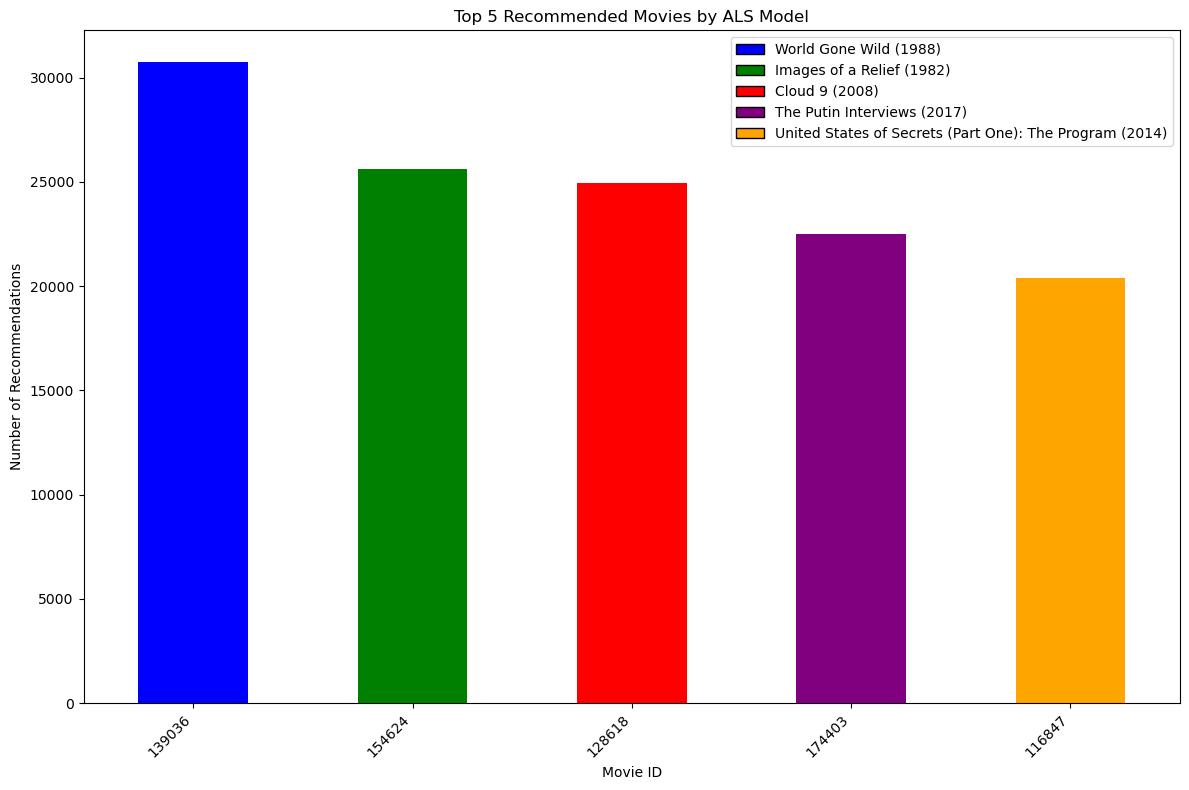

In [67]:
def als_recommend_visualization(recommendations):
    # Explode the recommendations column
    recs_exploded = recommendations.withColumn("rec_exp", explode("recommendations")).select("userId", col("rec_exp.movieId"), col("rec_exp.rating"))
    
    # Join the exploded recommendations with movies
    movies_df = spark.read.csv("dataset/movies.csv", header=True, inferSchema=True)
    recs_joined = recs_exploded.join(movies_df, "movieId").select("movieId", "userId", "title", "rating")

    # Collect the data to Pandas DataFrame
    recs_pd = recs_joined.toPandas()

    # Count the number of recommendations for each movie and get the top 5
    top_movie_ids = recs_pd['movieId'].value_counts().head(5).index
    top_movies = recs_pd[recs_pd['movieId'].isin(top_movie_ids)]
    top_movies_count = top_movies['movieId'].value_counts()

    # Get titles for the top movies
    top_movies_titles = top_movies.drop_duplicates(subset='movieId').set_index('movieId')['title'].to_dict()

    # Define custom colors for each bar
    custom_colors = ['blue', 'green', 'red', 'purple', 'orange']

    # Create a bar plot using Matplotlib
    plt.figure(figsize=(12, 8))
    ax = top_movies_count.plot(kind='bar', color=custom_colors)
    plt.xlabel('Movie ID') 
    plt.ylabel('Number of Recommendations')
    plt.title('Top 5 Recommended Movies by ALS Model')
    
    # Create a legend for the colors
    labels = [top_movies_titles[movieId] for movieId in top_movie_ids]
    handles = [plt.Rectangle((0,0),1,1, color=custom_colors[i], ec="k") for i in range(len(custom_colors))]
    plt.legend(handles, labels)
    ax.set_xticklabels(top_movie_ids, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    plt.close()


als_recommend_visualization(recommendations)

# Part 4: RF Recommend with Visualization

In [ ]:
def feature_engineering(spark, ratings_df):
    """
    Perform feature engineering for movie recommendations. This includes processing movie genres and tags,
    and applying one-hot encoding.

    Args:
    spark (SparkSession): SparkSession object for DataFrame operations.
    ratings_df (DataFrame): DataFrame containing movie ratings.

    Returns:
    DataFrame: A DataFrame with combined movie features ready for model training.
    """

    # Converts a list of vectors into a single vector by summing up each dimension.
    def sum_vectors(vectors):
        return Vectors.dense(sum(v[0] for v in vectors))

    sum_vectors_udf = udf(sum_vectors, VectorUDT())

    # Load and preprocess datasets
    movies_df = spark.read.csv("dataset/movies.csv", header=True, inferSchema=True)    # movieId, title, genres
    tags_df = spark.read.csv("dataset/tags.csv", header=True, inferSchema=True)    # userId, movieId, tag, timestamp
    print("Initial Movies DataFrame:", movies_df.take(5))
    print("Initial Tags DataFrame:", tags_df.take(5))

    # Process genres: split, explode, and one-hot encode
    movies_df = movies_df.withColumn("split_genres", split(col("genres"), "\|"))    # Split genres into individual genres
    movies_exploded = movies_df.withColumn("genre", explode(col("split_genres")))   # Explode genres into new rows
    genre_indexer = StringIndexer(inputCol="genre", outputCol="genreIndex")
    indexed_genre = genre_indexer.fit(movies_exploded).transform(movies_exploded)
    genre_encoder = OneHotEncoder(inputCol="genreIndex", outputCol="genreVec")
    encoded_genre = genre_encoder.fit(indexed_genre).transform(indexed_genre)
    print("Movies DataFrame after splitting genres:", movies_df.take(5))
    print("Movies DataFrame after splitting and exploding genres:", movies_exploded.take(5))
    print("Indexed Genre DataFrame:", indexed_genre.take(5))
    print("Encoded Genre DataFrame:", encoded_genre.take(5))

    # Aggregate the encoded genres back to movie level
    genre_aggregated = encoded_genre.groupBy("movieId").agg(collect_list("genreVec").alias("genreVecList"))
    genre_aggregated = genre_aggregated.withColumn("genresVec", sum_vectors_udf("genreVecList"))
    print("Aggregated Genre DataFrame:", genre_aggregated.take(5))

    # Process tags using StringIndexer + OneHotEncoder
    tag_indexer = StringIndexer(inputCol="tag", outputCol="tagIndex")
    tag_model = tag_indexer.fit(tags_df)
    indexed_tags = tag_model.transform(tags_df)
    tag_encoder = OneHotEncoder(inputCols=["tagIndex"], outputCols=["tagVec"])
    tags_encoded = tag_encoder.fit(indexed_tags).transform(indexed_tags)
    print("Indexed Tags DataFrame:", indexed_tags.take(5))
    print("Encoded Tags DataFrame:", tags_encoded.take(5))

    # Add a new column 'label' based on the condition
    ratings_df = ratings_df.withColumn('label', F.when(F.col('rating') >= 3.5, 2).otherwise(3))

    def parse_year(title):
    pattern = r"\((\d{4})\)"  # Regular expression pattern to extract the year
    match = re.search(pattern, title)
    if match:
        year_str = match.group(1)
        return int(year_str)
    else:
        return 1900
     # Extract movie year
    parse_year_udf = udf(parse_year, IntegerType())
    complete_data_df = complete_data_df.withColumn("movie_year", parse_year_udf(complete_data_df['title']))

    # Explode tag vectors into a list of features for each movie
    movie_tags_features = tags_encoded.groupBy('movieId').agg(F.collect_list('tagVec').alias('tagVectors'))
    movie_tags_features = movie_tags_features.withColumn('tagFeatures', sum_vectors_udf('tagVectors')).drop('tagVectors')
    print("Movie Tags Features DataFrame:", movie_tags_features.take(5))

    # Combine movie features with ratings
    complete_data_df = ratings_df.join(genre_aggregated.select("movieId", "genresVec"), "movieId").join(movie_tags_features, "movieId")
    print("Complete Data DataFrame after combining features with ratings:", complete_data_df.take(5))

    # Create feature vectors
    assembler = VectorAssembler(
    inputCols=["userId", "movieId", "timestamp", "movie_year", "label"] + ["genresVec", "tagFeatures"],
    outputCol="features"
    )    
    data_ready = assembler.transform(complete_data_df)

    return data_ready

# Assuming spark and ratings_df are defined earlier in your code
data_ready = feature_engineering(spark, ratings_df)
print(data_ready)


In [ ]:
def train_evaluate_visualize(data_ready):
    """
    Train, evaluate, and visualize movie recommendations using a Random Forest model.

    Args:
    data_ready (DataFrame): DataFrame containing prepared features for training.
    """

    # Splitting the dataset
    training_features, test_features = data_ready.randomSplit([0.7, 0.3])

    # Training the Random Forest model
    rf = RandomForestRegressor(featuresCol="features", labelCol="rating")
    model = rf.fit(training_features)

    # Evaluate model on test dataset
    predictions_df = model.transform(test_features)
    rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
    mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")

    # Calculate and output evaluation metrics
    rmse = rmse_evaluator.evaluate(predictions_df)
    mae = mae_evaluator.evaluate(predictions_df)
    print(f"Root Mean Square Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")

    #Calculate average predition rating of every movie
    avg_predictions_df = predictions_df.groupBy("movieId").avg("prediction")

    # Get top5 movie recommendations
    top_predictions = predictions_df.orderBy('avg(prediction)', ascending=False).limit(5)

    # Join with the movies dataframe to get movie titles
    movies_df = spark.read.csv("dataset/movies.csv", header=True, inferSchema=True)  # Load movies data
    top_movies_with_titles = top_predictions.join(movies_df, 'movieId').select('title', 'avg(prediction)')
    print(top_movies_with_titles)

    # Convert to pandas dataframe for visualization
    top_movies_pd = top_movies_with_titles.toPandas()
    top_movies_pd.set_index('title', inplace=True)

    # Plot
    plt.figure(figsize=(12, 8))
    top_movies_pd['avg(prediction)'].plot(kind='bar')
    plt.xlabel('Predicted Rating')
    plt.ylabel('Movie Title')
    plt.title('Top 5 Movie Recommendations')
    plt.tight_layout()
    plt.show()
    plt.close()


train_evaluate_visualize(data_ready)

# Part 5: Model Comparison

**ALS model**:
+ Advantages: It is suitable for large-scale data sets, can effectively handle sparsity problems, and is often used in recommendation systems.
+ Disadvantages: Need to adjust multiple parameters, sensitive to cold start issues.

**Random forest model**:
+ Advantages: It handles nonlinear relationships well and is less prone to overfitting.
+ Disadvantages: A large amount of feature engineering is required and the computational cost is high.